In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline

In [2]:
class Value:
    def __init__(self,data,_children=(),_op='',_label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op
        self._label = _label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __neg__(self):
        return self*-1
        
    def __sub__(self,other):
        return self+(-other)

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data,(self,other),'*')
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self*other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'^{other}')
        def _backward():
            self.grad += other*(self.data**(other-1.0))*out.grad
        out._backward = _backward
        return out
        
    def __truediv__(self, other): 
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'e^x')
        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward
        return out
        
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for v in node._prev:
                    build_topo(v)
                topo.append(node)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [220]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right
    
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # Create a record node for each value
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n._label,n.data,n.grad), shape='record')
        if n._op:
            # Create an op node if there's an operation
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [221]:
# inputs x1,x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')
# weights w1,w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')
# bias of the neuron
b = Value(6.8813735870195432, _label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1._label = 'x1*w1'
x2w2 = x2*w2; x2w2._label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n._label = 'n'
o = n.tanh(); o._label = 'o'
o.backward()

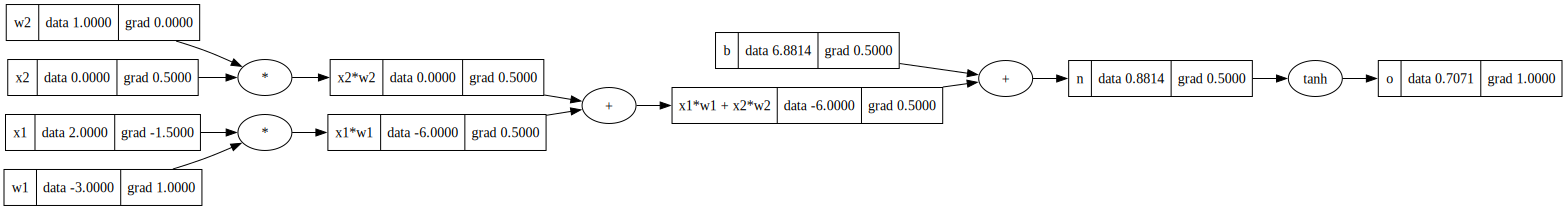

In [222]:
draw_dot(o)

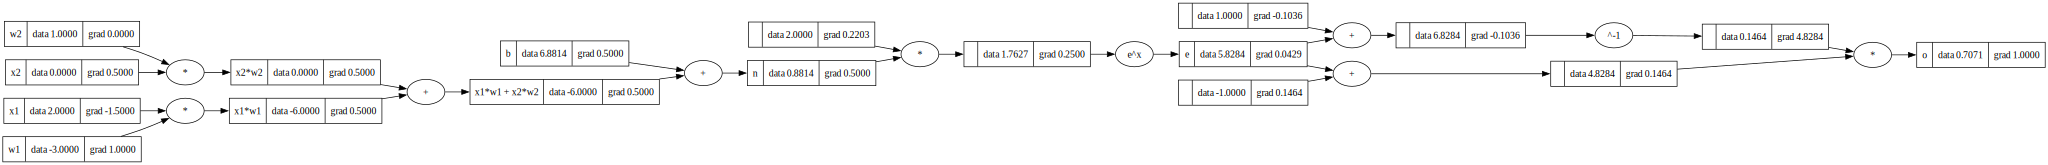

In [223]:
# inputs x1,x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')
# weights w1,w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')
# bias of the neuron
b = Value(6.8813735870195432, _label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1._label = 'x1*w1'
x2w2 = x2*w2; x2w2._label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n._label = 'n'
# ---
e = (2*n).exp();e._label = 'e'
o = (e-1)/(e+1); o._label = 'o'
# ---
o.backward()
draw_dot(o)

In [241]:
# now doing it in pytorch

import torch

x1 = torch.tensor(2.0).double(); x1.requires_grad=True
w1 = torch.tensor(-3.0).double(); w1.requires_grad=True
x2 = torch.tensor(0.0).double(); x2.requires_grad=True
w2 = torch.tensor(1.0).double(); w2.requires_grad=True
b = torch.tensor(6.8813735870195432).double(); b.requires_grad=True


n = w1*x1 + w2*x2 +b
o = torch.tanh(n)

print(o.data.item())

o.backward()
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [346]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        if len(self.w) != len(x):
            raise ValueError(f"Expected {len(self.w)} inputs, got {len(x)}")
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
        

class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self,nin,nouts):
        sz = [nin]+nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0,3.0,3.0]

n = MLP(3,[4,4,1])
n(x)

Value(data=-0.35998819743751764)

In [347]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [348]:
for k in range(20):
    # forward pass
    y_preds = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,y_preds))
    
    # backward pass
    for p in n.parameters():
        p.grad=0 # zero grad
    loss.backward()
    
    
    # update step
    for p in n.parameters():
        p.data+=-0.01*p.grad
    
    print(k,loss.data)

0 5.012741663845373
1 3.563889456227776
2 2.409898569355369
3 1.8638192827972127
4 1.5217844817339001
5 1.2736559088359818
6 1.0869373713858705
7 0.9426368109364229
8 0.8284384677472824
9 0.7362054523413843
10 0.6604233476783175
11 0.597244867985135
12 0.5439112052502565
13 0.4983958370277298
14 0.45917897559974646
15 0.42510032736129194
16 0.3952601978735071
17 0.36895136874301593
18 0.3456111249438628
19 0.32478681588956815


In [349]:
y_preds

[Value(data=0.7345343499406777),
 Value(data=-0.8029188001484588),
 Value(data=-0.6308398580091559),
 Value(data=0.7185846579190711)]